In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

np.random.seed(100)
%matplotlib inline
warnings.filterwarnings('ignore')

In [92]:
online_shoppers = pd.read_csv('online_shoppers_intention.csv')
online_shoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Machine Learning Phase

- Categorical  Encodings

In [93]:
from sklearn.preprocessing import LabelEncoder
df = online_shoppers.copy()

for col in df.select_dtypes('object'):
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

- We need to see the most correlated features to the target variable which is the Revenue column.
    - (ExitRates, BounceRates, ProductRelated, ProductRelated_Duration, PageValues) are the top correlated columns.

In [94]:
df.corr()['Revenue'].sort_values()

ExitRates                 -0.207071
BounceRates               -0.150673
VisitorType               -0.104726
SpecialDay                -0.082305
OperatingSystems          -0.014668
Region                    -0.011595
TrafficType               -0.005113
Browser                    0.023984
Weekend                    0.029295
Informational_Duration     0.070345
Month                      0.080150
Administrative_Duration    0.093587
Informational              0.095200
Administrative             0.138917
ProductRelated_Duration    0.152373
ProductRelated             0.158538
PageValues                 0.492569
Revenue                    1.000000
Name: Revenue, dtype: float64

- There are some Outliers in our columns we will try to detect them Using The IQR method

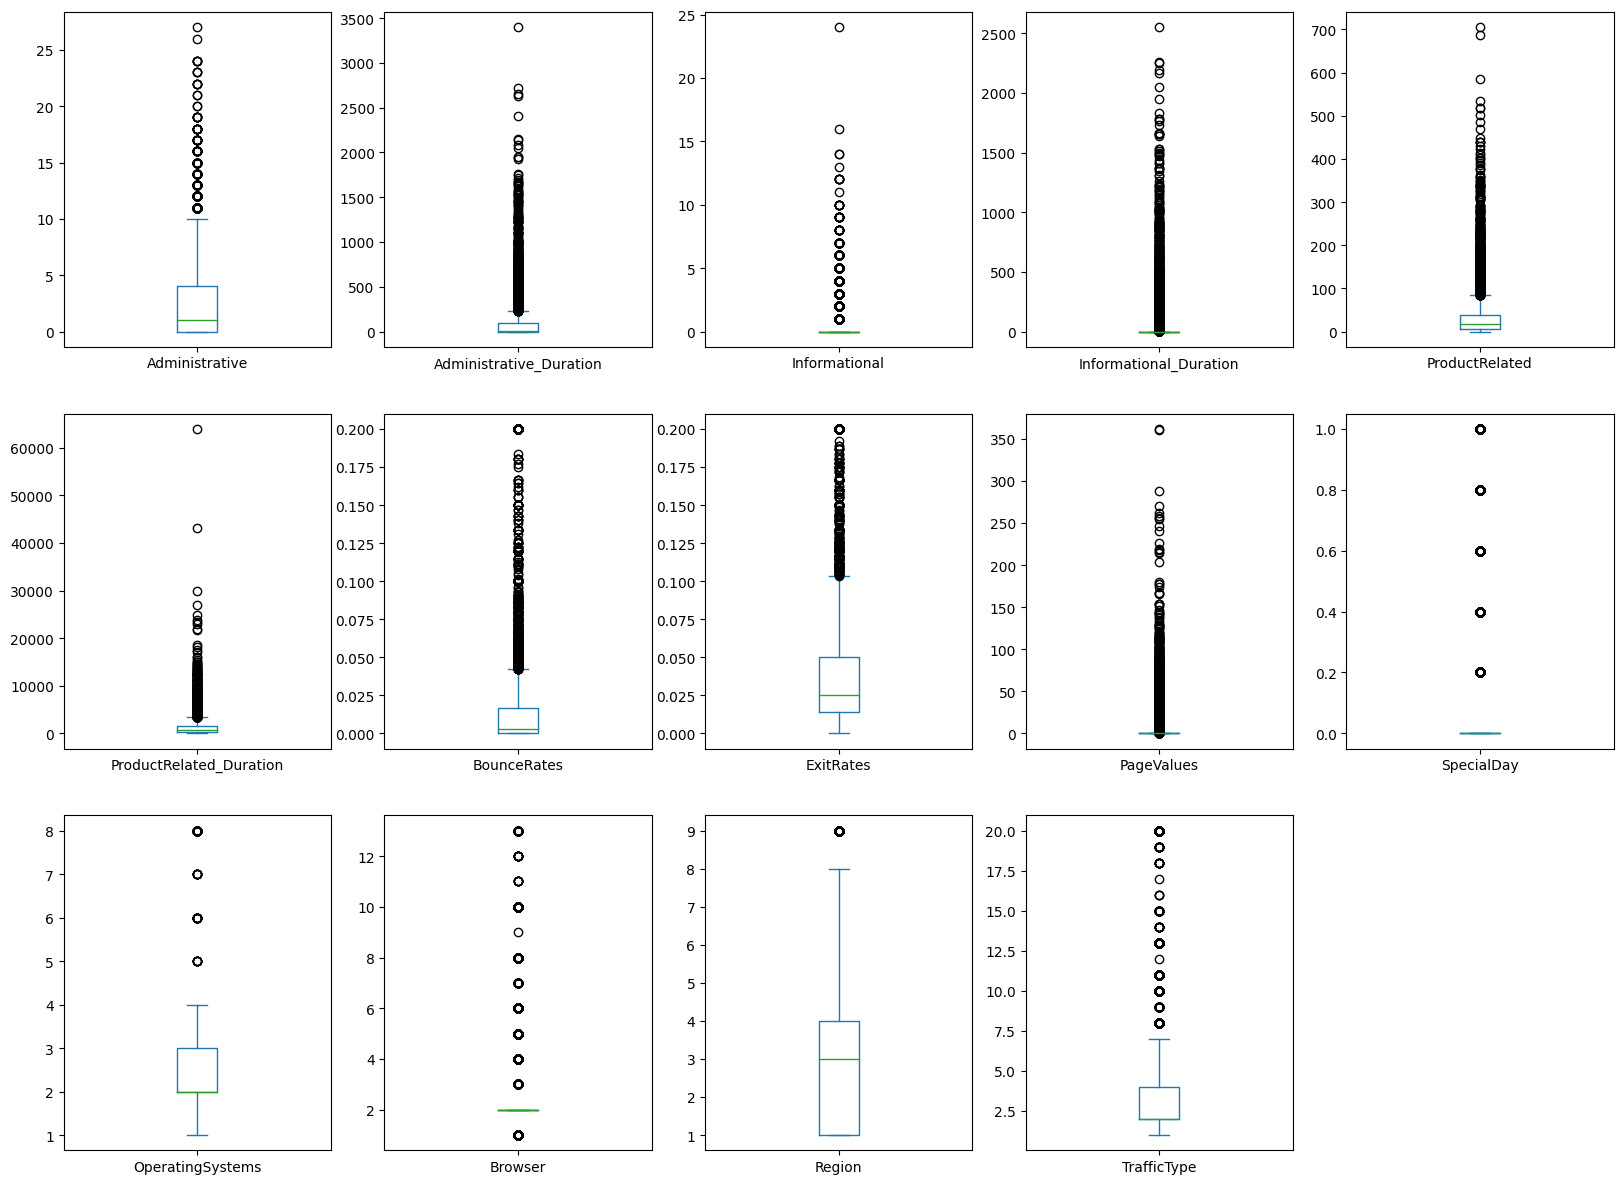

In [95]:
numerical_data = online_shoppers.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))

plt.savefig('figs/Box Plots.png', format='png')

#### Using the IQR(Inter Quartile Range) to identify outliers and Remove them.
- Calculating the Q1 and Q3 and IQR.
- Calculating the Lower_whisker and Upper_whisker.
- Getting the indecies of the outliers. I can't Drop all the outliers because the it contains 25 y-yes values so we may drop the y-no rows but keeping the y-yes rows.
- Dropping the data points with those indecies .

In [96]:
q3, q1 = np.percentile(df['PageValues'], [75, 25])
print(q3, q1)
print(len(df))

IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

0.0 0.0
12330
0.0


In [97]:
mask1 = df['PageValues'] > upper_bound
mask2 = df['PageValues'] < lower_bound

outliers_indecies = df[(mask1) | (mask2)].index

len(outliers_indecies)

2730

In [98]:
df.loc[outliers_indecies]['Revenue'].value_counts()

True     1538
False    1192
Name: Revenue, dtype: int64

In [99]:
df.drop(outliers_indecies, inplace=True)
df.shape

(9600, 18)

- Handling the imbalanced target variable.

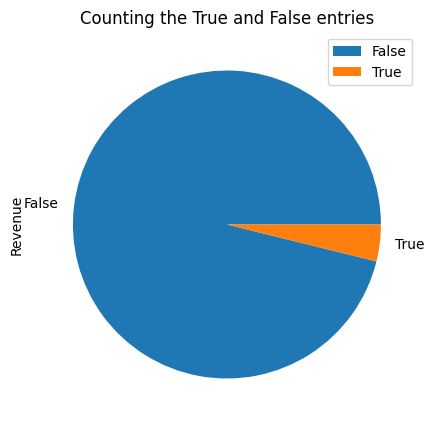

In [100]:
df['Revenue'].value_counts().plot.pie(figsize=(10, 5))
plt.legend()
plt.title('Counting the True and False entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

- Doing RandomOverSampling to balance the data.
- Seperating the X and y variables.

In [101]:
from imblearn.over_sampling import RandomOverSampler

X =  df.drop('Revenue', axis=1)
y = df['Revenue'].replace({False:0, True:1})

rus = RandomOverSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)

-  After  the random under sampling

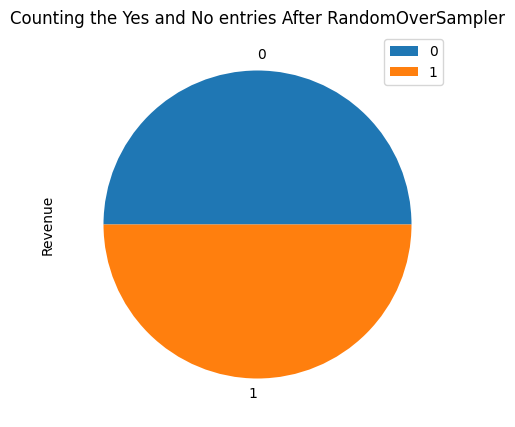

In [102]:
y_res.value_counts().plot.pie(figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries After RandomOverSampler')
plt.savefig('figs/Counting the Yes and No entries After RandomOverSampler.png', format='png')
plt.show()

### Model Comparison.

Knn 0.941 0.005
Dtc 0.981 0.001
Rdf 0.996 0.001
adb 0.807 0.007
grdb 0.865 0.003


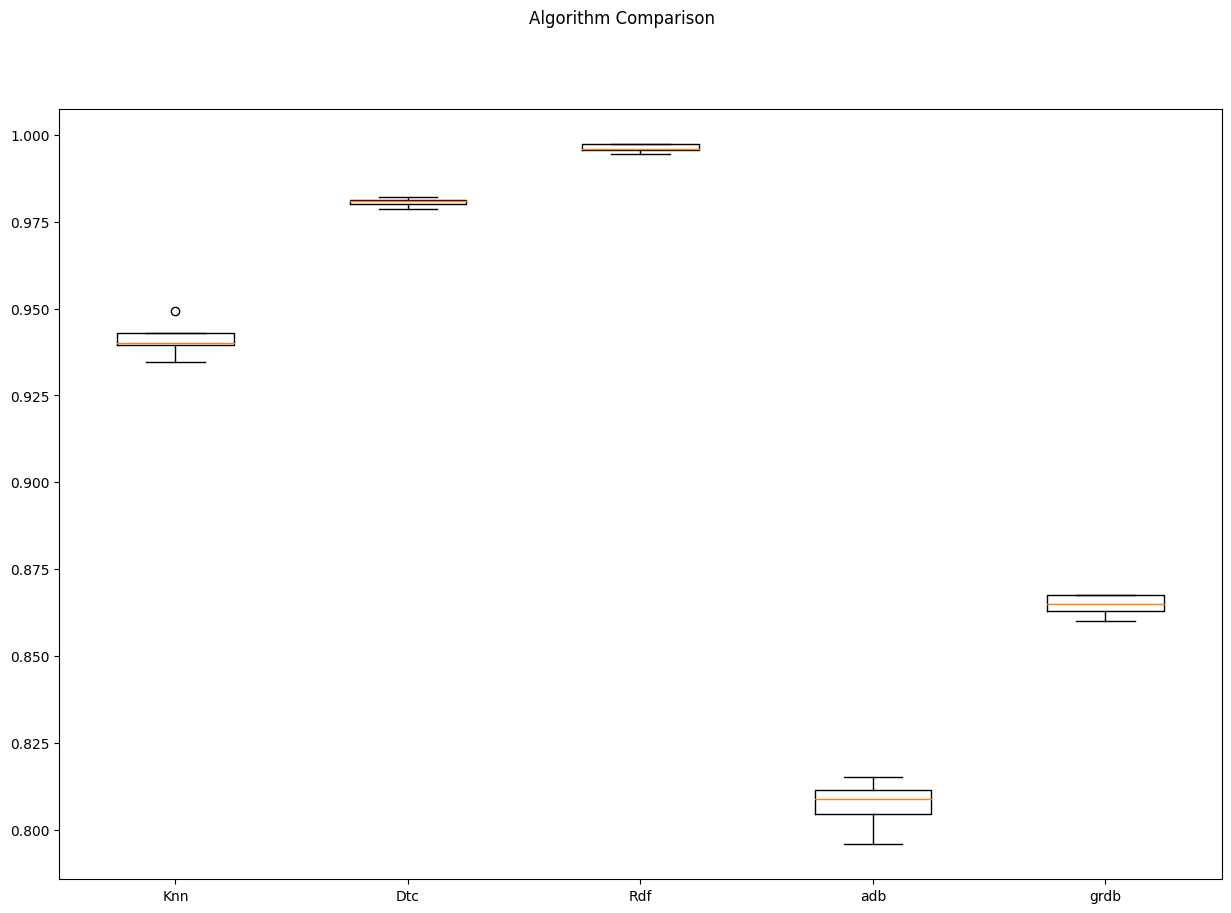

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    # ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    # ('Gaus', GaussianNB()),
    # ('LDA', LinearDiscriminantAnalysis()),
    # ('LogR', LogisticRegression(max_iter=1000)),
    # ('MLP', MLPClassifier(max_iter=1000))
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_res, y_res, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, np.round(cv_results.mean(), 3), np.round(cv_results.std(), 3))
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=0)

model = RandomForestClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [105]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[907   3]
 [  0 936]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       910
           1       1.00      1.00      1.00       936

    accuracy                           1.00      1846
   macro avg       1.00      1.00      1.00      1846
weighted avg       1.00      1.00      1.00      1846

Area Under Curve : 
 0.9983516483516484


In [108]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [109]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9983748645720477
